In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pingouin import ttest

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [2]:
data = pd.read_csv('customerchurn.csv')
data_orig = data.copy()

In [3]:
data.shape

(7043, 21)

# Data Preparation/EDA

In [4]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# total charges should be float64.. check what is causing the object data type
print([x for x in data['TotalCharges'] if any(char.isdigit() for char in x) == False])

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


In [6]:
# replace blanks with NaN
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan)
data['TotalCharges'] = data['TotalCharges'].astype('float64')

In [7]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [8]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
data = data.dropna().reset_index(drop=True)

In [10]:
data['SeniorCitizen'] = data['SeniorCitizen'].replace(0, 'False').replace(1, 'True')

data[['Partner', 'Dependents', 'PhoneService', 
      'PaperlessBilling']] = data[['Partner', 'Dependents', 'PhoneService', 
                                   'PaperlessBilling']].replace('Yes', 'True').replace('No', 'False')

data['MultipleLines'] = data['MultipleLines'].replace('Yes', 'Multiple Lines').replace('No', 'Single Line')
data['InternetService'] = data['InternetService'].replace('No', 'No internet service')
data['OnlineSecurity'] = data['OnlineSecurity'].replace('Yes', 'Online Security').replace('No', 'No Online Security')
data['OnlineBackup'] = data['OnlineBackup'].replace('Yes', 'Online Backup').replace('No', 'No Online Backup')
data['DeviceProtection'] = data['DeviceProtection'].replace('Yes', 'Device Protection').replace('No', 'No Device Protection')
data['TechSupport'] = data['TechSupport'].replace('Yes', 'Tech Support').replace('No', 'No Tech Support')
data['StreamingTV'] = data['StreamingTV'].replace('Yes', 'Steaming TV').replace('No', 'Not Streaming TV')
data['StreamingMovies'] = data['StreamingMovies'].replace('Yes', 'Streaming Movies').replace('No', 'Not Streaming Movies')

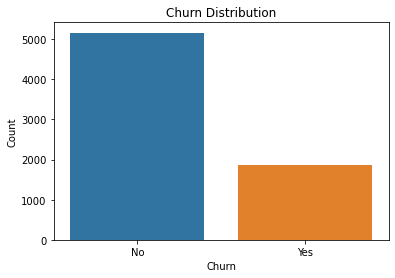

In [11]:
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.ylabel('Count')
plt.show()

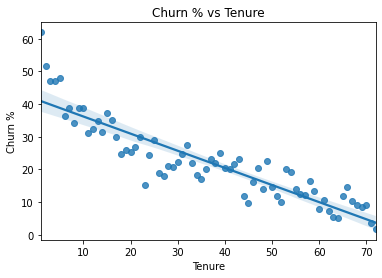

In [12]:
ct = pd.crosstab(data['tenure'], data['Churn'])
ct['Churn %'] = round(100*ct['Yes']/(ct['No']+ct['Yes']), 2)

sns.regplot(x='tenure', y='Churn %', data=ct.reset_index())
plt.title('Churn % vs Tenure')
plt.xlabel('Tenure')
plt.show()

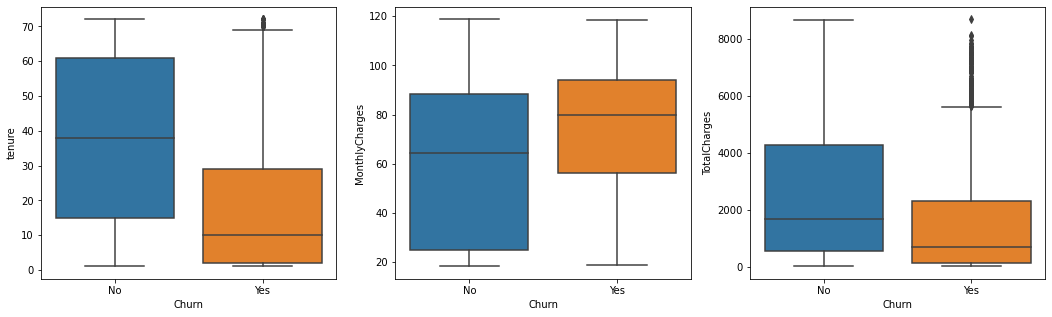

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(ax=ax[0], y='tenure', x='Churn', data=data)
sns.boxplot(ax=ax[1], y='MonthlyCharges', x='Churn', data=data)
sns.boxplot(ax=ax[2], y='TotalCharges', x='Churn', data=data)
plt.show()

In [14]:
# ttests:
no = data[data['Churn']=='No']
yes = data[data['Churn']=='Yes']

print('Tenure:', ttest(no['tenure'], yes['tenure'])['p-val'])
print('')
print('Monthly Charges:', ttest(no['MonthlyCharges'], yes['MonthlyCharges'])['p-val'])
print('')
print('Total Charges:', ttest(no['TotalCharges'], yes['TotalCharges'])['p-val'])

Tenure: T-test    2.347075e-234
Name: p-val, dtype: float64

Monthly Charges: T-test    2.657357e-72
Name: p-val, dtype: float64

Total Charges: T-test    1.152494e-75
Name: p-val, dtype: float64


In [15]:
# define contingency table and calculate % churn
def ct(df, column):
    ct = pd.crosstab(df[column], df['Churn'])
    ct['Churn %: Yes'] = round(100*ct['Yes']/(ct['No']+ct['Yes']), 2)
    ct['Churn %: No'] = round(100*ct['No']/(ct['No']+ct['Yes']), 2)
    ct = ct.reset_index()
    ct = pd.melt(ct, id_vars=[column], value_vars=['Churn %: Yes', 'Churn %: No'], 
                 value_name='Percentage of Total')
    return ct

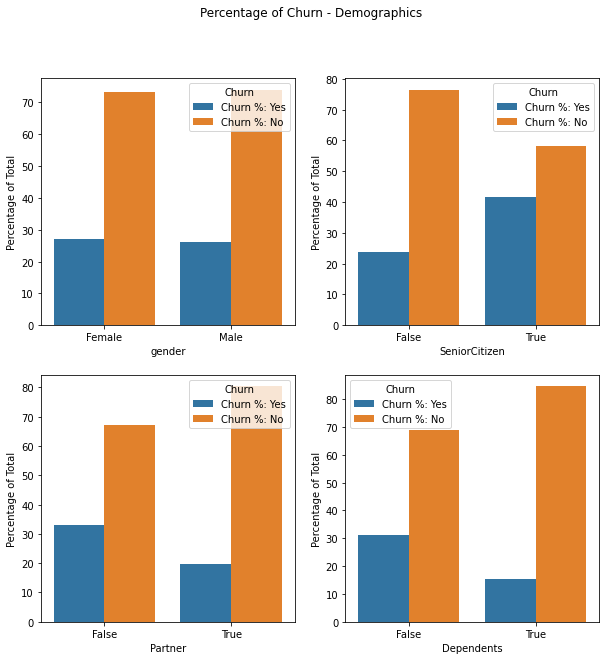

In [16]:
# churn percentage for demographics
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot(ax=ax[0, 0], x='gender', y='Percentage of Total', hue='Churn', data=ct(data, 'gender'))
sns.barplot(ax=ax[0, 1], x='SeniorCitizen', y='Percentage of Total', hue='Churn', data=ct(data, 'SeniorCitizen'))
sns.barplot(ax=ax[1, 0], x='Partner', y='Percentage of Total', hue='Churn', data=ct(data, 'Partner'))
sns.barplot(ax=ax[1, 1], x='Dependents', y='Percentage of Total', hue='Churn', data=ct(data, 'Dependents'))

plt.suptitle('Percentage of Churn - Demographics')
plt.show()

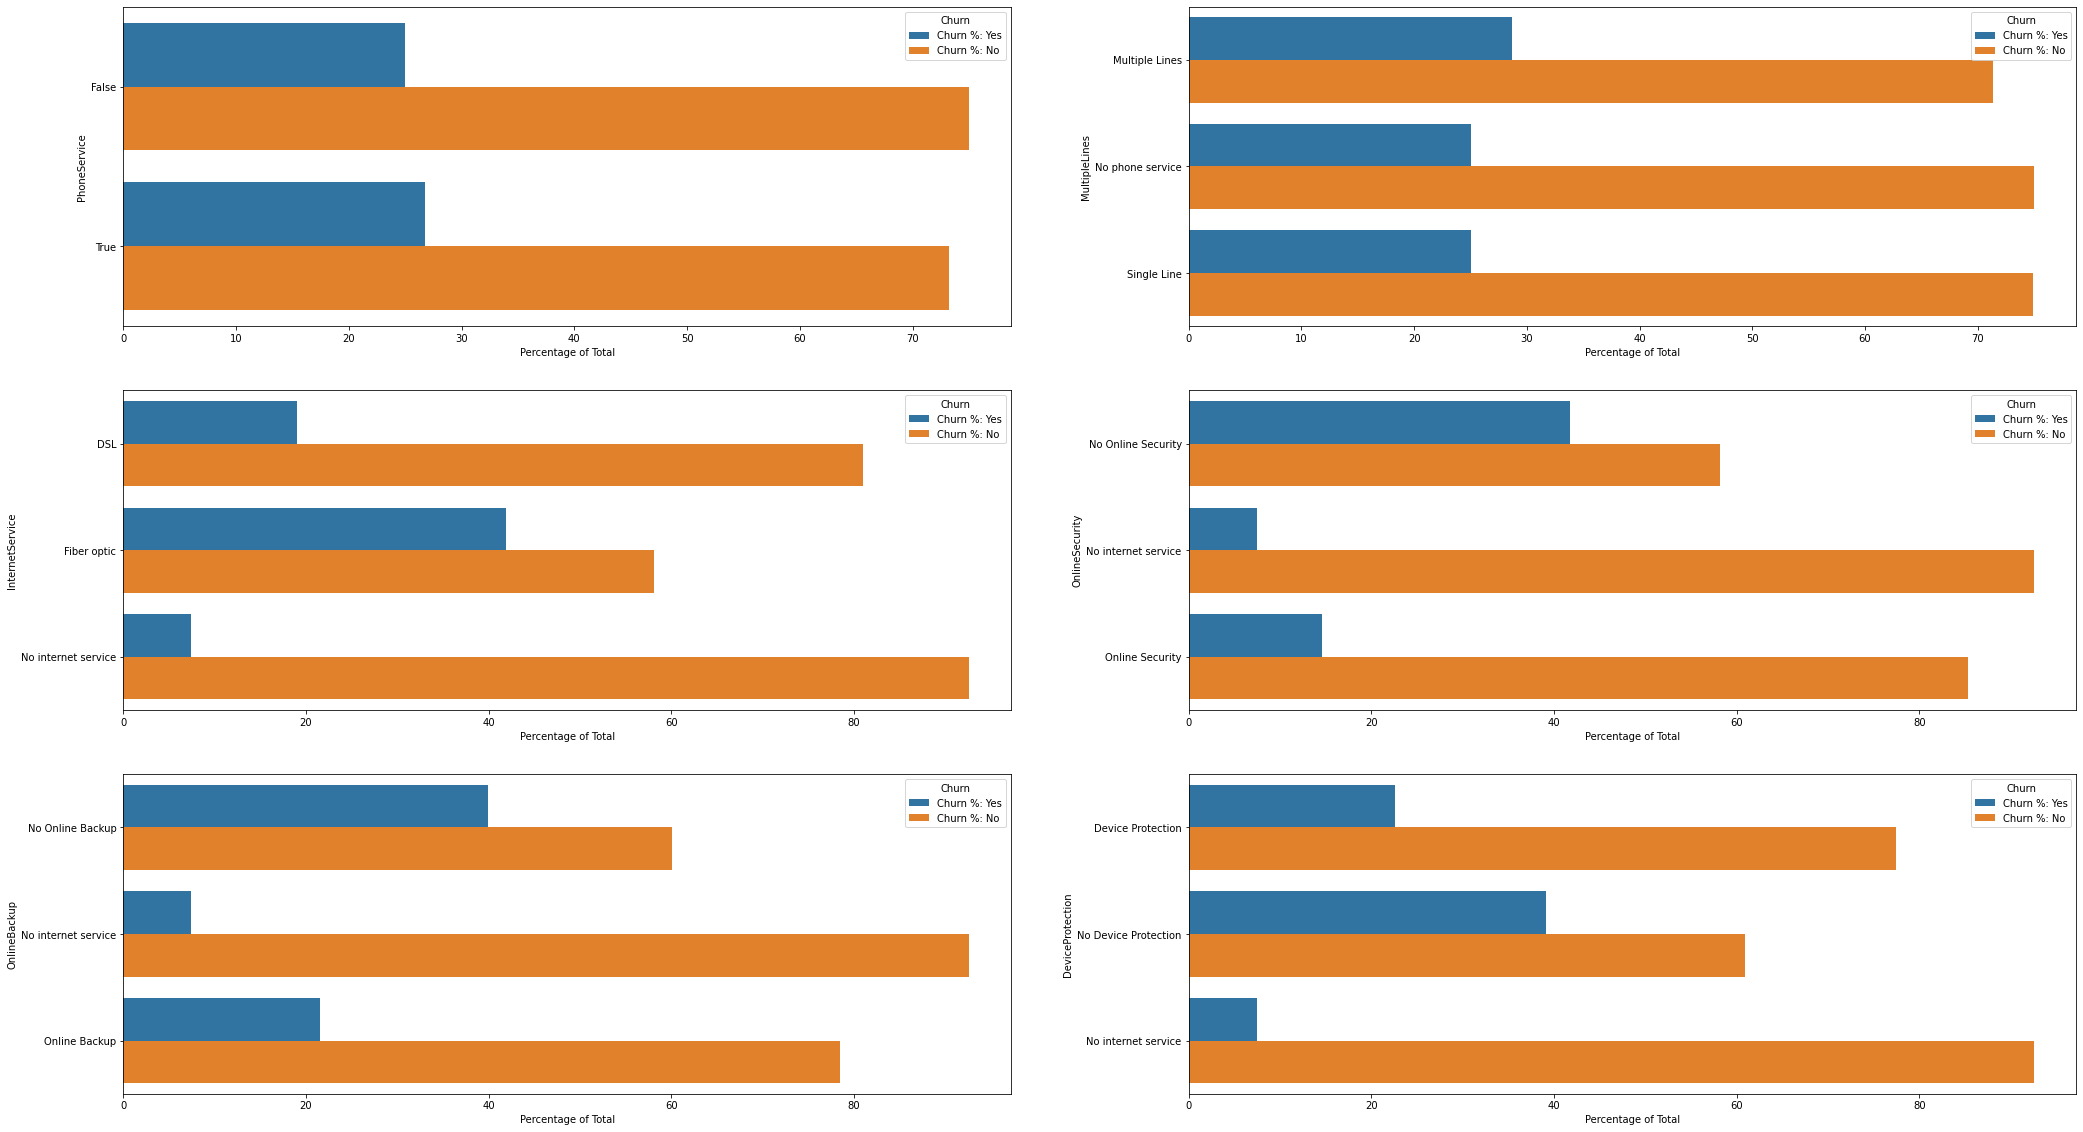

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(35, 20))

sns.barplot(ax=ax[0, 0], y='PhoneService', x='Percentage of Total', hue='Churn', data=ct(data, 'PhoneService'))
sns.barplot(ax=ax[0, 1], y='MultipleLines', x='Percentage of Total', hue='Churn', data=ct(data, 'MultipleLines'))

sns.barplot(ax=ax[1, 0], y='InternetService', x='Percentage of Total', hue='Churn', data=ct(data, 'InternetService'))
sns.barplot(ax=ax[1, 1], y='OnlineSecurity', x='Percentage of Total', hue='Churn', data=ct(data, 'OnlineSecurity'))

sns.barplot(ax=ax[2, 0], y='OnlineBackup', x='Percentage of Total', hue='Churn', data=ct(data, 'OnlineBackup'))
sns.barplot(ax=ax[2, 1], y='DeviceProtection', x='Percentage of Total', hue='Churn', data=ct(data, 'DeviceProtection'))

plt.show()

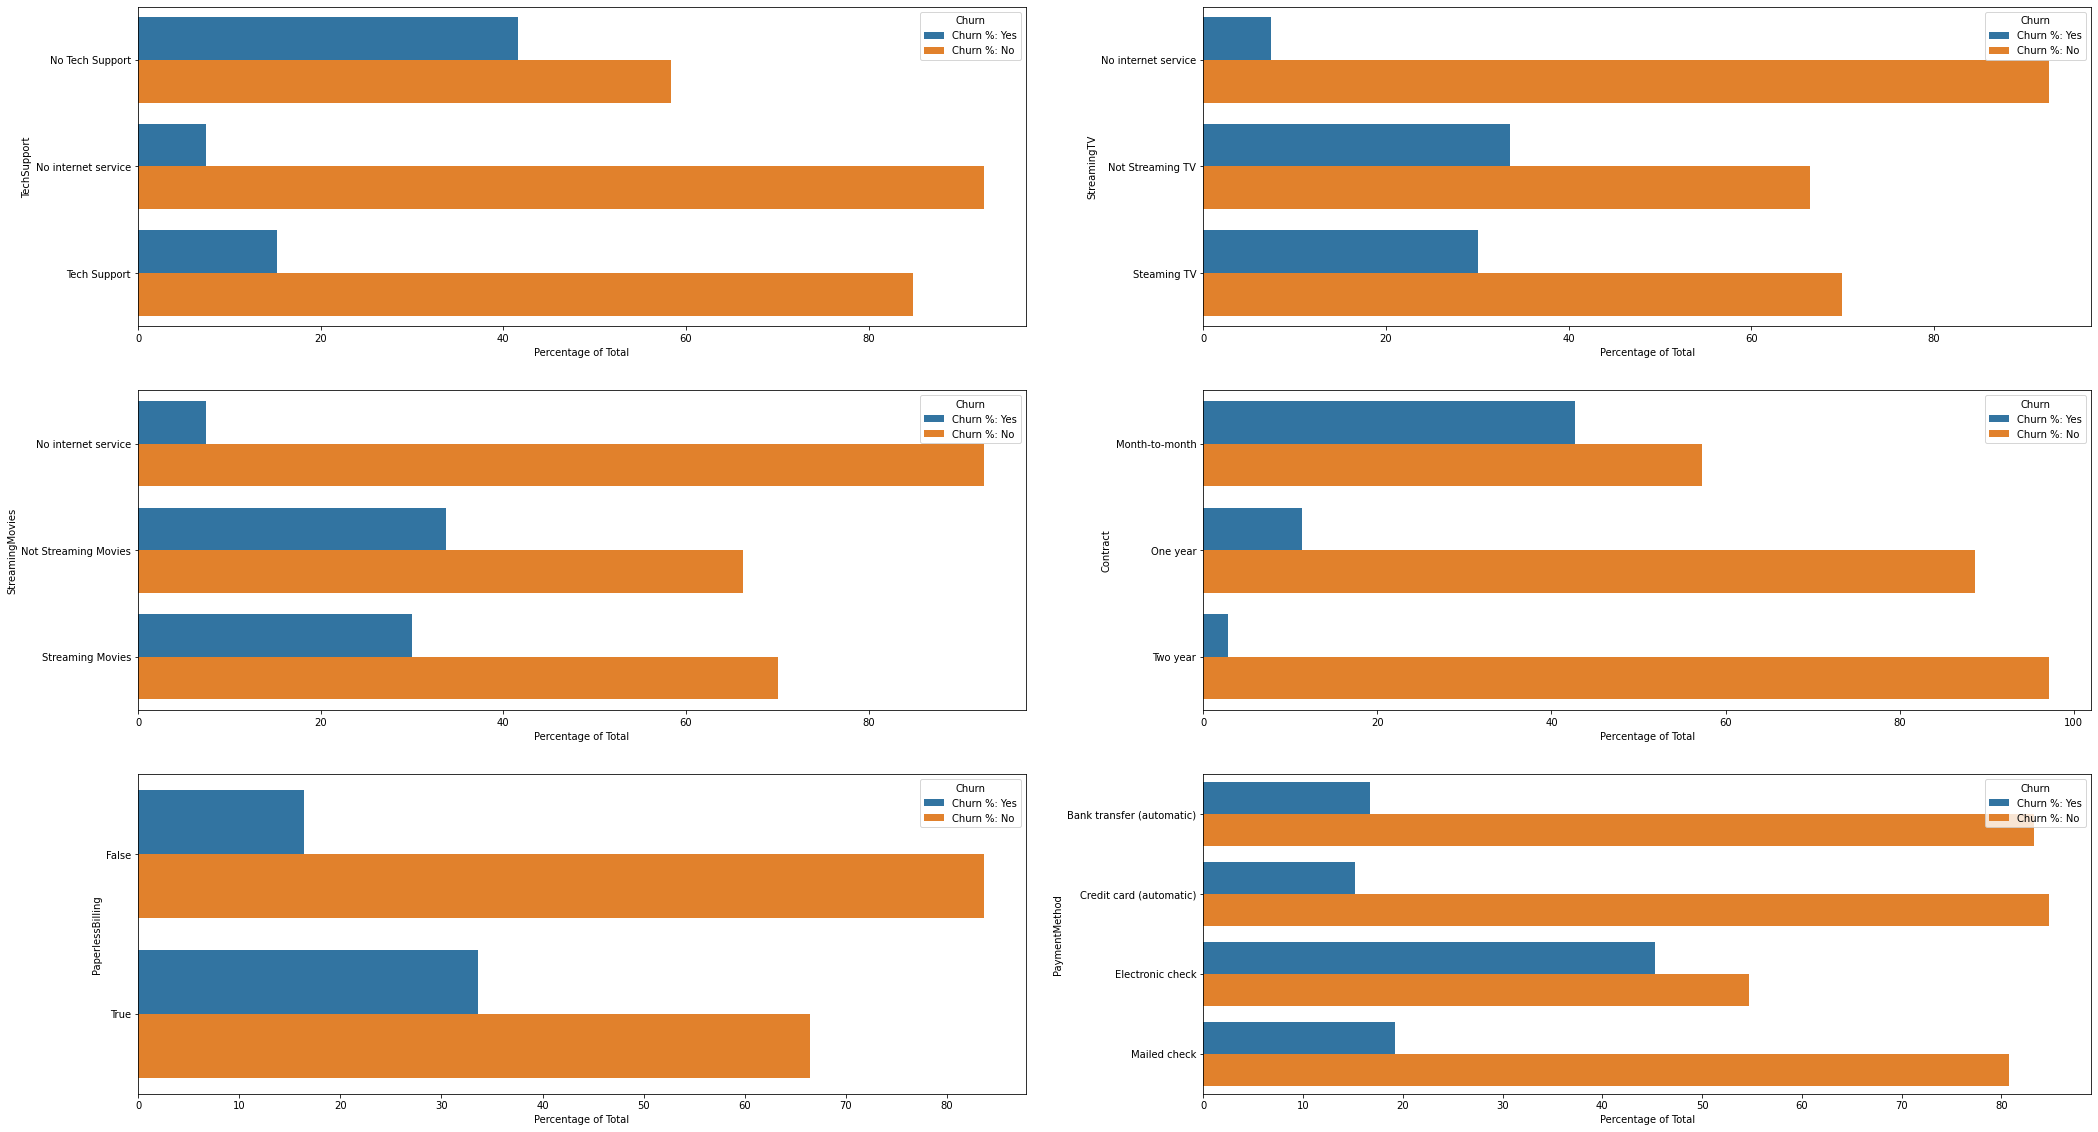

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(35, 20))

sns.barplot(ax=ax[0, 0], y='TechSupport', x='Percentage of Total', hue='Churn', data=ct(data, 'TechSupport'))
sns.barplot(ax=ax[0, 1], y='StreamingTV', x='Percentage of Total', hue='Churn', data=ct(data, 'StreamingTV'))

sns.barplot(ax=ax[1, 0], y='StreamingMovies', x='Percentage of Total', hue='Churn', data=ct(data, 'StreamingMovies'))
sns.barplot(ax=ax[1, 1], y='Contract', x='Percentage of Total', hue='Churn', data=ct(data, 'Contract'))

sns.barplot(ax=ax[2, 0], y='PaperlessBilling', x='Percentage of Total', hue='Churn', data=ct(data, 'PaperlessBilling'))
sns.barplot(ax=ax[2, 1], y='PaymentMethod', x='Percentage of Total', hue='Churn', data=ct(data, 'PaymentMethod'))

plt.show()

In [19]:
# combining random over sampling and random under sampling to fix imbalanced target variable
X_data = data.iloc[:, :-1].copy()
y_data = data.iloc[:, -1].values

ros = RandomOverSampler(sampling_strategy=0.6)
X_ros, y_ros = ros.fit_resample(X_data, y_data)
print(Counter(y_ros))

rus = RandomUnderSampler(sampling_strategy=0.8)
X_co, y_co = rus.fit_resample(X_ros, y_ros)
print(Counter(y_co))

Counter({'No': 5163, 'Yes': 3097})
Counter({'No': 3871, 'Yes': 3097})


In [20]:
sampling_data = X_co.copy()
sampling_data['Churn'] = y_co

# SKLearn

In [21]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score

## Feature Encoding

In [22]:
X_df = sampling_data.iloc[:, 1:-1].copy()
y = sampling_data.iloc[:, -1].values

# encoding binary categorical variables:
binary_col = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
              'PhoneService', 'PaperlessBilling']

for col in binary_col:
    le = preprocessing.LabelEncoder()
    X_df[col] = le.fit_transform(X_df[col])

# one-hot-encoding for the rest of the categorical variables:
cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
  'Contract', 'PaymentMethod']

X_df = pd.get_dummies(X_df, columns=cols, drop_first=True)
X = X_df.values

# class encoding:
le_class = preprocessing.LabelEncoder()
y = le_class.fit_transform(y)

In [23]:
# 70/30 train/test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# scale features:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Feature Selection

Reducing the dimensionality of the dataset by using sequential backward selection.

In [24]:
#implement SBS
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import f1_score

class SBS():
    def __init__(self, estimator, k_features, scoring=f1_score, test_size=0.2, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

### Logistic Regression

In [25]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train_std, y_train)
lr_pred = lr.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != lr_pred).sum())
print('Accuracy with all features: %.3f' % accuracy_score(y_test, lr_pred))
print('Classification Report:')
print(classification_report(y_test, lr_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, lr_pred))

Misclassified examples: 496
Accuracy with all features: 0.763
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1162
           1       0.72      0.75      0.74       929

    accuracy                           0.76      2091
   macro avg       0.76      0.76      0.76      2091
weighted avg       0.76      0.76      0.76      2091

Confusion Matrix:
[[894 268]
 [228 701]]


In [26]:
# running SBS on the data:
sbs_lr = SBS(lr, k_features=1)
sbs_lr.fit(X_train_std, y_train)

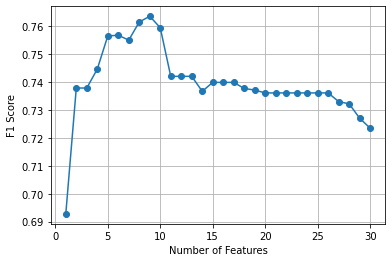

In [27]:
k_feat = [len(k) for k in sbs_lr.subsets_]

plt.plot(k_feat, sbs_lr.scores_, marker='o')
plt.ylabel('F1 Score')
plt.xlabel('Number of Features')
plt.grid()
plt.show()

for this collection of records, it appears that 9 features if the lowest number of features that will give us the highest f1 score

In [28]:
# print columns for the 21th index of SBS subsets which holds the 9 features
k_lr = list(sbs_lr.subsets_[21])
print(X_df.columns[k_lr])

Index(['SeniorCitizen', 'tenure', 'PhoneService', 'TotalCharges',
       'OnlineBackup_Online Backup', 'TechSupport_Tech Support',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Electronic check'],
      dtype='object')


In [29]:
lr.fit(X_train_std[:, k_lr], y_train)
print('Accuracy with 10 features:', lr.score(X_test_std[:, k_lr], y_test))
print('Accuracy with all features: %.3f' % accuracy_score(y_test, lr_pred))

Accuracy with 10 features: 0.74701099952176
Accuracy with all features: 0.763


### Support Vector Machine

In [30]:
svm = SVC(random_state=1)
svm.fit(X_train_std, y_train)
svm_pred = svm.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != svm_pred).sum())
print('Accuracy with all features: %.3f' % accuracy_score(y_test, svm_pred))
print('Classification Report:')
print(classification_report(y_test, svm_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_pred))

Misclassified examples: 495
Accuracy with all features: 0.763
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1162
           1       0.72      0.76      0.74       929

    accuracy                           0.76      2091
   macro avg       0.76      0.76      0.76      2091
weighted avg       0.77      0.76      0.76      2091

Confusion Matrix:
[[889 273]
 [222 707]]


In [31]:
sbs_svm = SBS(svm, k_features=1)
sbs_svm.fit(X_train_std, y_train)

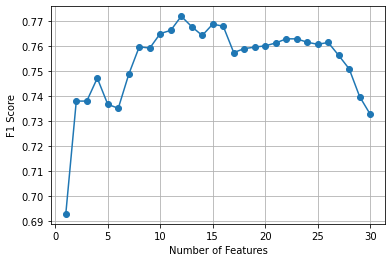

In [32]:
k_feat = [len(k) for k in sbs_svm.subsets_]

plt.plot(k_feat, sbs_svm.scores_, marker='o')
plt.ylabel('F1 Score')
plt.xlabel('Number of Features')
plt.grid()
plt.show()

for this collection of records, it appears that 12 features is the lowest number of features that will give us the highest f1 score

In [33]:
# print columns for the 18th index of SBS subsets which holds the 12 features
k_svm = list(sbs_svm.subsets_[18])
print(X_df.columns[k_svm])

Index(['SeniorCitizen', 'Partner', 'tenure', 'PaperlessBilling',
       'MonthlyCharges', 'MultipleLines_Single Line',
       'DeviceProtection_No Device Protection', 'TechSupport_Tech Support',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check'],
      dtype='object')


In [34]:
svm.fit(X_train_std[:, k_svm], y_train)
print('Accuracy with 10 features:', svm.score(X_test_std[:, k_svm], y_test))
print('Accuracy with all features: %.3f' % accuracy_score(y_test, svm_pred))

Accuracy with 10 features: 0.7474892395982783
Accuracy with all features: 0.763


### Random Forest

In [35]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train_std, y_train)
rf_pred = rf.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != rf_pred).sum())
print('Accuracy with all features: %.3f' % accuracy_score(y_test, rf_pred))
print('Classification Report:')
print(classification_report(y_test, rf_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_pred))

Misclassified examples: 376
Accuracy with all features: 0.820
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1162
           1       0.78      0.83      0.80       929

    accuracy                           0.82      2091
   macro avg       0.82      0.82      0.82      2091
weighted avg       0.82      0.82      0.82      2091

Confusion Matrix:
[[944 218]
 [158 771]]


In [36]:
sbs_rf = SBS(rf, k_features=1)
sbs_rf.fit(X_train_std, y_train)

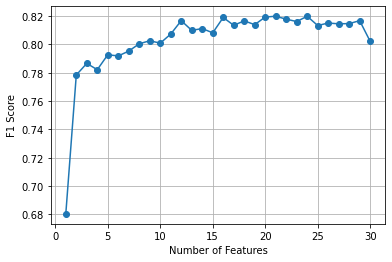

In [37]:
k_feat = [len(k) for k in sbs_rf.subsets_]

plt.plot(k_feat, sbs_rf.scores_, marker='o')
plt.ylabel('F1 Score')
plt.xlabel('Number of Features')
plt.grid()
plt.show()

for this collection of records, it appears that 16 features is the lowest number of features that will give us the highest f1 score

In [38]:
# print columns for the 14th index of SBS subsets which holds the 16 features
k_rf = list(sbs_rf.subsets_[14])
print(X_df.columns[k_rf])

Index(['SeniorCitizen', 'Partner', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'MultipleLines_Single Line',
       'InternetService_No internet service', 'OnlineBackup_Online Backup',
       'DeviceProtection_No internet service', 'StreamingTV_Not Streaming TV',
       'StreamingTV_Steaming TV', 'StreamingMovies_Not Streaming Movies',
       'StreamingMovies_Streaming Movies', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check'],
      dtype='object')


In [39]:
rf.fit(X_train_std[:, k_rf], y_train)
print('Accuracy with 10 features:', rf.score(X_test_std[:, k_rf], y_test))
print('Accuracy with all features: %.3f' % accuracy_score(y_test, rf_pred))

Accuracy with 10 features: 0.8173122907699665
Accuracy with all features: 0.820


In [40]:
print("F1 Scores")
print("Logistic Regression:", f1_score(y_test, lr_pred))
print("Support Vector Machine:", f1_score(y_test, svm_pred))
print("Random Forest Classifier:", f1_score(y_test, rf_pred))

F1 Scores
Logistic Regression: 0.7386722866174921
Support Vector Machine: 0.7407019381875326
Random Forest Classifier: 0.8039624608967675


### Feature Discussion

In [41]:
#which features were chosen across all classifiers:
lr_columns = X_df.columns[k_lr]
svm_columns = X_df.columns[k_svm]
rf_columns = X_df.columns[k_rf]

lr_svm = np.intersect1d(lr_columns, svm_columns)
common_columns = np.intersect1d(lr_svm, rf_columns)
print(common_columns)

['Contract_Two year' 'PaymentMethod_Electronic check' 'SeniorCitizen']


In [42]:
#which features did not appear in the SBS for any classifier:
lr_not_there = np.setdiff1d(X_df.columns, lr_columns)
svm_not_there = np.setdiff1d(X_df.columns, svm_columns)
rf_not_there = np.setdiff1d(X_df.columns, rf_columns)

lr_svm_not_there = np.intersect1d(lr_not_there, svm_not_there)
unimportant_columns = np.intersect1d(lr_svm_not_there, rf_not_there)
print(unimportant_columns)

['Dependents' 'InternetService_Fiber optic'
 'MultipleLines_No phone service' 'OnlineBackup_No internet service'
 'OnlineSecurity_No internet service' 'OnlineSecurity_Online Security'
 'PaymentMethod_Mailed check' 'TechSupport_No internet service' 'gender']


# PyCaret

In [43]:
from pycaret.classification import *

In [44]:
clf = setup(sampling_data, target='Churn', ignore_features=['customerID'])

,Description,Value
0,session_id,5524
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(6968, 21)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


In [45]:
best_model = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8177,0.8973,0.8217,0.7787,0.7991,0.6325,0.6340,0.0980
et,Extra Trees Classifier,0.8112,0.8960,0.7984,0.7802,0.7887,0.6181,0.6188,0.0930
lightgbm,Light Gradient Boosting Machine,0.7929,0.8710,0.7915,0.7529,0.7713,0.5824,0.5834,0.0350
catboost,CatBoost Classifier,0.7933,0.8726,0.7896,0.7545,0.7711,0.5829,0.5842,0.7650
gbc,Gradient Boosting Classifier,0.7767,0.8586,0.7641,0.7396,0.7512,0.5488,0.5497,0.1290
dt,Decision Tree Classifier,0.7664,0.7697,0.7905,0.7133,0.7493,0.5319,0.5352,0.0100
ada,Ada Boost Classifier,0.7667,0.8502,0.7576,0.7263,0.7410,0.5289,0.5301,0.0470
lda,Linear Discriminant Analysis,0.7617,0.8398,0.7473,0.7229,0.7346,0.5186,0.5192,0.0110
ridge,Ridge Classifier,0.7615,0.0000,0.7469,0.7228,0.7343,0.5182,0.5188,0.0060
nb,Naive Bayes,0.7416,0.8272,0.7984,0.6757,0.7317,0.4859,0.4926,0.0060


In [46]:
print(best_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5524, verbose=0,
                       warm_start=False)


In [47]:
# hyperparameter tuning
tuned_best_model = tune_model(best_model)
print(tuned_best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8115,0.8890,0.8837,0.7393,0.8051,0.6253,0.6347
1,0.8033,0.8623,0.8698,0.7333,0.7957,0.6087,0.6169
2,0.8197,0.9027,0.8465,0.7679,0.8053,0.6381,0.6407
3,0.8053,0.8930,0.8651,0.7381,0.7966,0.6122,0.6193
4,0.8033,0.8687,0.8148,0.7586,0.7857,0.6043,0.6056
5,0.8217,0.8871,0.8472,0.7722,0.8079,0.6423,0.6447
6,0.8299,0.8854,0.8472,0.7854,0.8151,0.6581,0.6597
7,0.8234,0.8852,0.8605,0.7676,0.8114,0.6464,0.6501
8,0.8049,0.8724,0.8651,0.7381,0.7966,0.6114,0.6186
9,0.8049,0.8719,0.8279,0.7542,0.7894,0.6084,0.6107


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=280,
                       n_jobs=-1, oob_score=False, random_state=5524, verbose=0,
                       warm_start=False)


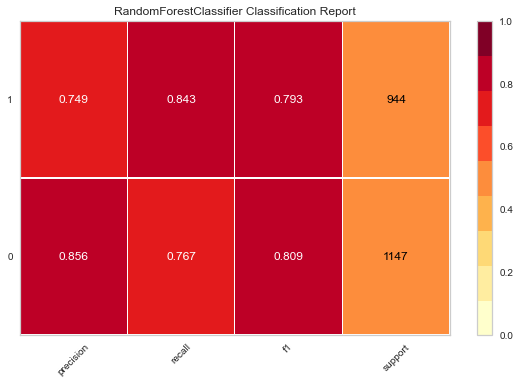

In [48]:
# classification report
plot_model(tuned_best_model, plot='class_report')

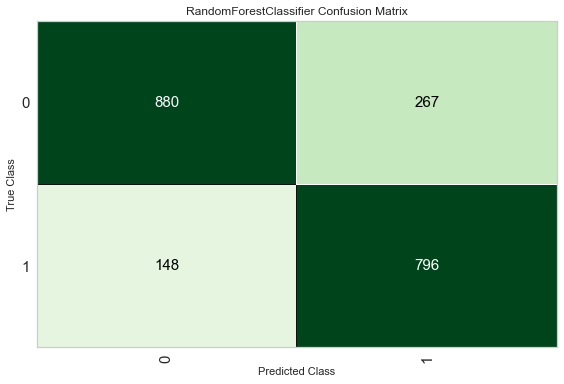

In [49]:
# confusion matrix
plot_model(tuned_best_model, plot='confusion_matrix')

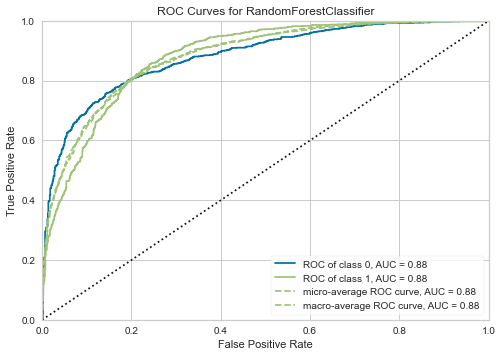

In [50]:
# AUC plot
plot_model(tuned_best_model)

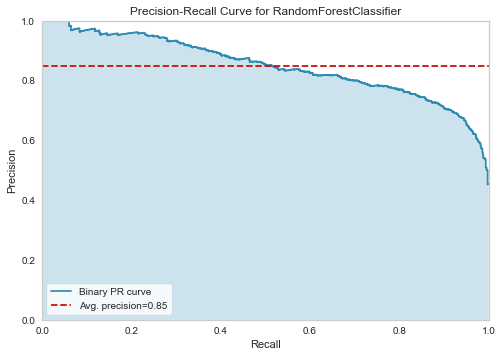

In [51]:
# precision recall curve
plot_model(tuned_best_model, plot='pr')